In [1]:
import torch
import cv2 as cv
import numpy as np
import pandas as pd
import math
import os
import glob
import matplotlib.pyplot as plt

# Data Prerocessing

In [2]:
## construct images and labels

def process_img(folder ):
    matrix_all = []
    label_all =[]
    imgs = glob.glob('%s/*.jpg'%folder)
    labels = glob.glob('%s/*.att'%folder)
    
    # read images
    for img in imgs:
        image = cv.imread(img)
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        gray_matrix = np.array(gray_image)
        
        matrix_all.append(gray_matrix)
        
    # read labels
    for label in labels:
        with open(label, 'r') as file:
            for idx, line in enumerate(file):
                if idx ==1:
                    #print(line)
                    single_label = line.split('.')[0]
                    label_all.append(int(single_label))
    return matrix_all, label_all

### shape of data: trainset:1000, testset:250
train_X,train_Y = process_img('TrainImages')
test_X, test_Y = process_img('TestImages')

In [3]:


## few matrixs are in shape 102, which should be deleted
for flag, single_set in enumerate([train_X, test_X]):
    for idx, mtx in enumerate(single_set):
        # delete the last column and row
        if mtx.shape[0] == 102 or mtx.shape[1] == 102:
            mtx = mtx[:-1, :-1]
            # substitute original matrix to new one
            if flag == 0:
                train_X[idx] = mtx
                #del train_x[idx]
                #del train_y[idx]
                
            elif flag ==1:
                test_X[idx] = mtx
                #del test_x[idx]
                #del test_y[idx]                
# type( train_x[1] ), test_x[2].shape,  test_x[2] len(train_y) ,train_y[2], len(test_x)


train_X = [ele.reshape(1,-1) for ele in train_X]
test_X = [ele.reshape(1,-1) for ele in test_X]
train_X = np.vstack(train_X)   ## 1000 * 10201
test_X = np.vstack(test_X)   # 250*10201

# (1). Label Distribution

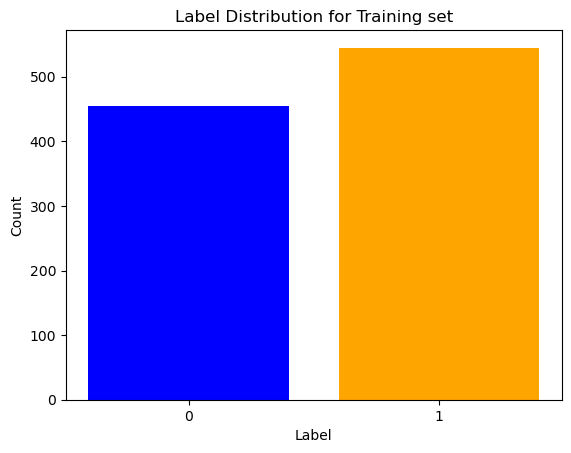

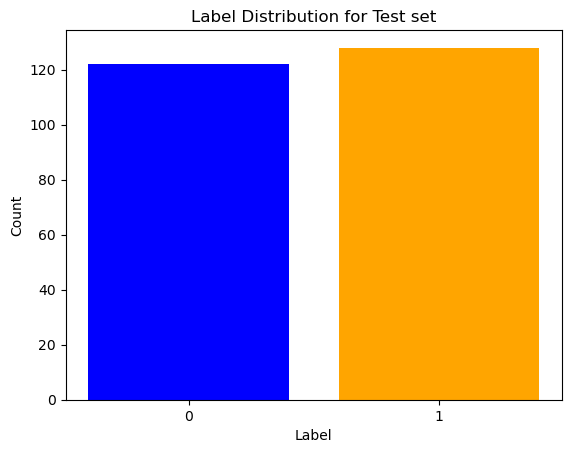

In [4]:
for label_dist, set_name in zip([train_Y, test_Y],['Training set','Test set']):
    unique_labels, label_counts = np.unique(label_dist, return_counts=True)
    plt.figure(   )
    # 创建直方图
    plt.bar(unique_labels, label_counts, tick_label=unique_labels, color=['blue', 'orange'])

    # 设置图表标题和轴标签
    plt.title('Label Distribution for %s'%set_name)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# (2). Single Layer Perceptron

Apply Rosenblatt’s perceptron (single layer perceptron) to your assigned task. 
After the training procedure, calculate the classification accuracy for both the 
training set and test set, and evaluate the performance of the perceptron

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)  # 输入层到输出层的全连接层

    def forward(self, x):
        x = torch.sigmoid(self.fc(x))  # relu activation function
        #print(x)
        return x

# 假设 train_X, train_y, test_X, test_y 分别是训练集和测试集的特征和标签数据

def SLP_model(train_x, test_x, train_y, test_y):
    # 将训练集和测试集转换为PyTorch张量
    #  train_X_tensor should be in shape 1000*10201
    train_X_tensor = torch.tensor(train_x, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    test_X_tensor = torch.tensor(test_x, dtype=torch.float32)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

    # 创建Rosenblatt感知器模型
    input_size = train_x.shape[1]
    perceptron = Perceptron(input_size)

    # 定义损失函数和优化器
    criterion = nn.MSELoss()  # 二元交叉熵损失函数
    optimizer = optim.Adam(perceptron.parameters(), lr=0.001)

    # 训练模型
    num_epochs = 1000
    for epoch in range(num_epochs):
        # 前向传播
        outputs = perceptron(train_X_tensor)
        #print(outputs[:5])
        loss = criterion(outputs, train_y_tensor.unsqueeze(1))  # 使用unsqueeze添加一个维度，使标签与预测值形状相匹配  train_y_tensor.unsqueeze(1)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
    # 在训练集和测试集上评估模型
    with torch.no_grad():
        train_outputs = (perceptron(train_X_tensor) > 0.5).float()
        #print(train_outputs)
        train_accuracy = (train_outputs == train_y_tensor.unsqueeze(1)).float().mean().item()
        #print("Training set accuracy:", train_accuracy)

        test_outputs = (perceptron(test_X_tensor) > 0.5).float()
        test_accuracy = (test_outputs == test_y_tensor.unsqueeze(1)).float().mean().item()
        #print("Test set accuracy:", test_accuracy)
    return 



In [35]:
## without PCA
SLP_model(train_X, test_X, train_Y, test_Y)

Epoch [100/1000], Loss: 0.5450
Epoch [200/1000], Loss: 0.5450
Epoch [300/1000], Loss: 0.5450
Epoch [400/1000], Loss: 0.5450
Epoch [500/1000], Loss: 0.5450
Epoch [600/1000], Loss: 0.5450
Epoch [700/1000], Loss: 0.5450
Epoch [800/1000], Loss: 0.5450
Epoch [900/1000], Loss: 0.5450
Epoch [1000/1000], Loss: 0.5450


# (3). PCA 

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Epoch [100/1000], Loss: 0.5092
Epoch [200/1000], Loss: 0.5060
Epoch [300/1000], Loss: 0.4979
Epoch [400/1000], Loss: 0.3081
Epoch [500/1000], Loss: 0.2468
Epoch [600/1000], Loss: 0.2461
Epoch [700/1000], Loss: 0.2460
Epoch [800/1000], Loss: 0.2460
Epoch [900/1000], Loss: 0.2460
Epoch [1000/1000], Loss: 0.2460


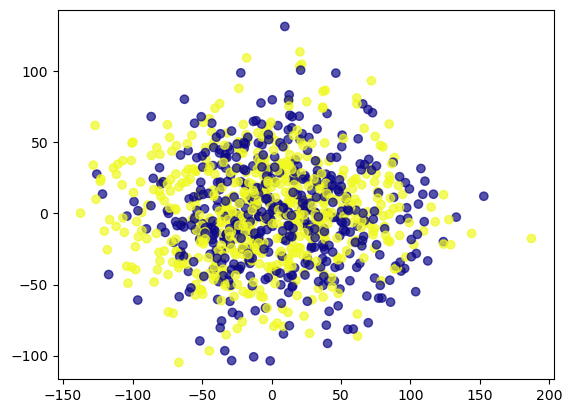

In [38]:
scaler = StandardScaler()
train_x_st = scaler.fit_transform(np.array(train_X).reshape(1000,10201) ) # 1000*10201
test_x_st = scaler.fit_transform(np.array(test_X).reshape(250,10201))

pca = PCA(n_components=2)  # 降到2维
train_pca1 = pca.fit_transform(np.array(train_x_st).reshape(1000,10201))
test_pca1 = pca.fit_transform(np.array(test_x_st).reshape(250,10201))
plt.scatter(train_pca1[:, 0], train_pca1[:, 1], c=train_Y,cmap = 'plasma',alpha = 0.7)
SLP_model(train_pca1, test_pca1, train_Y, test_Y)

H:\Anaconda3_2021\anaconda\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


((1000, 2), (1000, 10201))

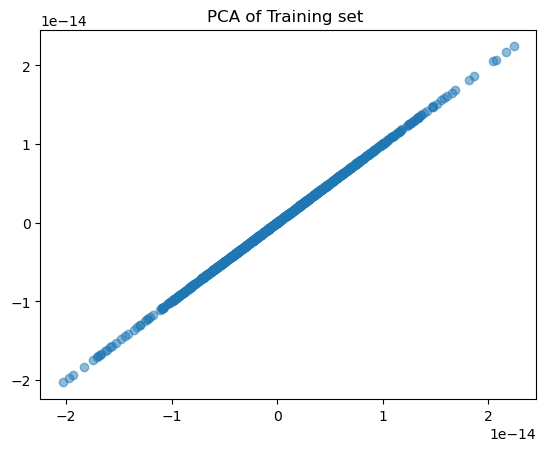

In [12]:
#  # standardize data
#  scaler = StandardScaler()
#  train_x_st = scaler.fit_transform(np.array(train_X).reshape(1000,10201) ) # 1000*10201
#  test_x_st = scaler.fit_transform(np.array(test_X).reshape(250,10201))
#  
#  # covariance matrix
#  cov_matrix = (train_x_st.T @ train_x_st) / (train_x_st.shape[0] - 1)  # 10201*10201
#  
#  # 3 SVD
#  eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)  # ndarray 
#  
#  n_components = 2
#  principal_components = eigenvectors[:, -n_components:]  # 10201*5
#  train_X_projected = train_x_st @ principal_components  # 1000*5
#  test_X_projected = test_x_st @ principal_components
#  plt.scatter(train_X_projected[:,0], train_X_projected[:,1], c=train_Y, cmap='viridis',alpha = 0.5)
#  plt.title('PCA of Training set ')
#  
#  ## single layer model with PCA
#  training_model(train_X_projected, test_X_projected, train_Y, test_Y)

# (4). MLP with batch training

Apply MLP to your assigned task using batch mode training. After the training 
procedure, calculate the classification accuracy for both the training set and test
set, and evaluate the performance of the network.

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(10201, 100)
        self.fc2 = nn.Linear(100,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

def MLP_batch_model(train_x, test_x, train_y, test_y):
    train_X_tensor = torch.tensor(train_x, dtype=torch.float32)

    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)

    test_X_tensor = torch.tensor(test_x, dtype=torch.float32)

    test_y_tensor = torch.tensor(test_y, dtype=torch.float32)

    model = MLP()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    print(train_X_tensor.shape)
    
    num_epochs = 100
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            #print(inputs, labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, train_y_tensor.unsqueeze(1))
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    # Step 5: Evaluate the performance of your model
    with torch.no_grad():
        # Evaluate on training set
        train_outputs = model(train_X_tensor)
        print(train_outputs[:45])
        train_predictions_1 = (train_outputs >= 0.5).float()
        #print(train_predictions_1[:5])
        train_accuracy = (train_predictions == train_y_tensor.unsqueeze(1)).float().mean()

        # Evaluate on test set
        test_outputs = model(test_X_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        test_accuracy = (test_predictions == test_y_tensor.unsqueeze(1)).float().mean()

    print(f'Training Accuracy: {train_accuracy.item()*100:.2f}%')
    print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')    
    return 



In [147]:
MLP_batch_model(train_X, test_X, train_Y, test_Y)

torch.Size([1000, 10201])
Epoch [10/100], Loss: 0.2480
Epoch [20/100], Loss: 0.2481
Epoch [30/100], Loss: 0.2480
Epoch [40/100], Loss: 0.2480
Epoch [50/100], Loss: 0.2480
Epoch [60/100], Loss: 0.2480
Epoch [70/100], Loss: 0.2480
Epoch [80/100], Loss: 0.2480
Epoch [90/100], Loss: 0.2480
Epoch [100/100], Loss: 0.2480
tensor([[0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],
        [0.5449],

TypeError: 'NoneType' object is not subscriptable

In [141]:
MLP_batch_model(train_pca1, test_pca1, train_Y, test_Y) 
# change self.fc1 = nn.Linear(10201, 32) from 10201 to 2

torch.Size([1000, 2])
Epoch [10/100], Loss: 0.2490
Epoch [20/100], Loss: 0.2481
Epoch [30/100], Loss: 0.2481
Epoch [40/100], Loss: 0.2479
Epoch [50/100], Loss: 0.2479
Epoch [60/100], Loss: 0.2482
Epoch [70/100], Loss: 0.2479
Epoch [80/100], Loss: 0.2480
Epoch [90/100], Loss: 0.2480
Epoch [100/100], Loss: 0.2480
tensor([[0.5491],
        [0.5462],
        [0.5409],
        [0.5438],
        [0.5426]])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])
Training Accuracy: 54.50%
Test Accuracy: 51.20%


# (5). MLP with sequential training

In [94]:
def MLP_sequential_model(train_x, test_x, train_y, test_y):
    train_X_tensor = torch.tensor(train_x, dtype=torch.float32)

    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    train_y_tensor = train_y_tensor.unsqueeze(1)
    test_X_tensor = torch.tensor(test_x, dtype=torch.float32)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32)
    test_y_tensor = test_y_tensor.unsqueeze(1)
    
    model = MLP()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
    print(len(train_X_tensor[2]), (train_y_tensor[2]))
    
    num_epochs = 100
    for epoch in range(num_epochs):
        for i in range(len(train_X_tensor)):
            inputs = train_X_tensor[i]
            labels = train_y_tensor[i]

            optimizer.zero_grad()
            outputs = model(inputs)
            #print(outputs.shape, labels.shape)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

    # Step 5: Evaluate the performance of your model
    with torch.no_grad():
        # Evaluate on training set
        train_outputs = model(train_X_tensor)
        train_predictions = (train_outputs >= 0.5).float()
        train_accuracy = (train_predictions == train_y_tensor).float().mean()

        # Evaluate on test set
        test_outputs = model(test_X_tensor)
        test_predictions = (test_outputs >= 0.5).float()
        test_accuracy = (test_predictions == test_y_tensor).float().mean()

    print(f'Training Accuracy: {train_accuracy.item()*100:.2f}%')
    print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')    
    return 

In [95]:
MLP_sequential_model(train_X, test_X, train_Y, test_Y)

10201 tensor([0.])
Training Accuracy: 54.50%
Test Accuracy: 51.20%


#### The model accuracy of BATCH  and SEQUENTIAL are same. However, batch mode uses much less time than sequential method.

# (6). placing eyes
You may notice that all the images, either for training or test, are already aligned 
by placing eyes at a certain location. Do you think it is necessary to do so? 
Justify your answer.

In [ ]:
## construct images and labels

def rotate_img(folder ):
    matrix_all = []
    label_all =[]
    imgs = glob.glob('%s/*.jpg'%folder)
    labels = glob.glob('%s/*.att'%folder)
    selected_images = random.sample(image_files, len(image_files) // 2)
    
    # read images
    for img in imgs:
        image = cv.imread(img)
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        gray_matrix = np.array(gray_image)
        
        matrix_all.append(gray_matrix)
        
    # read labels
    for label in labels:
        with open(label, 'r') as file:
            for idx, line in enumerate(file):
                if idx ==1:
                    #print(line)
                    single_label = line.split('.')[0]
                    label_all.append(int(single_label))
    return matrix_all, label_all

### shape of data: trainset:1000, testset:250
train_X,train_Y = process_img('TrainImages')
test_X, test_Y = process_img('TestImages')

In [ ]:
# rotate images randomly by 90,180,270 degrees
import os
import random
import cv2

# 设置图片目录和保存目录
image_dir = 'path/to/your/image/directory'
save_dir = 'path/to/your/save/directory'

# 确保保存目录存在
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 获取图片列表
image_files = os.listdir(image_dir)

# 随机选取一半的图片
selected_images = random.sample(image_files, len(image_files) // 2)

# 对选中的图片进行旋转
for image_file in selected_images:
    # 读取图片
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    # 旋转图片 90 度
    rotated_image_90 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    save_path_90 = os.path.join(save_dir, f'{os.path.splitext(image_file)[0]}_rotated_90.jpg')
    cv2.imwrite(save_path_90, rotated_image_90)

    # 旋转图片 -90 度
    rotated_image_minus_90 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    save_path_minus_90 = os.path.join(save_dir, f'{os.path.splitext(image_file)[0]}_rotated_minus_90.jpg')
    cv2.imwrite(save_path_minus_90, rotated_image_minus_90)
